# <p style="text-align: center;">Deep Learning Project par Fatma Zahra Zakhama</p>
# <p style="text-align: center;">M2 Big Data & AI</p>

## **Presentation of the competition**

* la compétition de classification de mélanome SIIM-ISIC est une compétition d'apprentissage automatique  organisée, par la Collaboration internationale d'imagerie de la peau (ISIC) et la Société d'imagerie informatique en médecine (SIIM), sur Kaggle visant à améliorer la précision de **la détection de mélanome en utilisant des images démoscopiques**. Le mélanome est un type de cancer de la peau qui peut être mortel s'il n'est pas détecté et traité à temps.

* Dans cette compétition, On dispose  d'un jeu de données de plus de 33 000 images de lésions cutanées, comprenant à la fois des mélanomes et des lésions cutanées bénignes. 

> **L'objectif est de développer un modèle qui puisse classer correctement les images en mélanomes ou bénignes**.

* La compétition utilise l'ISIC Archive, qui est la plus grande banque de données d'images dermoscopiques de lésions cutanées de qualité contrôlée au monde. Les images dans le jeu de données ont été collectées à partir de différentes sources et comprennent des images cliniques et de recherche. Les images sont annotées par des dermatologues expérimentés et comprennent des informations sur le sexe, l'âge et l'emplacement du patient, ainsi que sur le site anatomique de la lésion.
 

## **Import libraries**

In [ ]:
# General libraries 
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil
import pathlib
# Visualizations
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
# Work with images
from skimage.transform import rotate
from skimage import io
import cv2 as cv
import PIL
from PIL import Image
# Model Development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy import expand_dims
from matplotlib import pyplot

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [5]:
pip install focal-loss










     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 13.8 MB/s eta 0:00:0000:0100:01














     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 16.8 MB/s eta 0:00:0000:0100:01




























  Attempting uninstall: typing-extensions

    Found existing installation: typing_extensions 4.1.1

    Uninstalling typing_extensions-4.1.1:

      Successfully uninstalled typing_extensions-4.1.1

  Attempting uninstall: numpy

    Found existing installation: numpy 1.21.6

    Uninstalling numpy-1.21.6:

      Successfully uninstalled numpy-1.21.6

  Attempting uninstall: h5py

    Found existing installation: h5py 3.7.0

    Uninstalling h5py-3.7.0:

      Successfully uninstalled h5py-3.7.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed

## **EDA : Exploratory Data Analysis**

In [ ]:
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train_path='/kaggle/input/siim-isic-melanoma-classification/train.csv'
test_path='/kaggle/input/siim-isic-melanoma-classification/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
print('Train  : ', train.shape)
print('Test   : ', test.shape)

### **Les colones :**

* **image_name**- identifiant unique, pointe vers le nom de fichier de l'image DICOM correspondante.
* **patient_id** - identifiant unique du patient
* **sex** - le sexe du patient (s'il est inconnu, il sera vide)
* **age_approx** - âge approximatif du patient au moment de l'imagerie
* **anatom_site_general_challenge** - emplacement du site imagé
* **diagnostic** - informations détaillées sur le diagnostic (train uniquement)
* **benign_malignant** - indicateur de malignité de la lésion imagée
* **target** - version binarisée de la variable cible

> On peut remarquer que la colone **benign_malignant** et **target** représentent la meme chose , si benign alors target 0 sinon 1.

In [2]:
display(train.head())
train.info()

NameError: name 'train' is not defined

In [ ]:
display(test.head())
test.info()

In [ ]:
for i in train.columns:
    print('\t\t\t',i,'\n')
    print(train[i].value_counts(normalize=True))
    print('------'*10)

In [ ]:
for i in train.columns:
    print('\t\t\t',i,'\n')
    print(train[i].value_counts(normalize=True))
    print('------'*10)

In [ ]:
# check for the missing values
def missing_values(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    plt.show()
def missing_values_table(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[total>0]
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data=missing_data[percent>0]
    return(missing_data)

                 Missing Values of Train


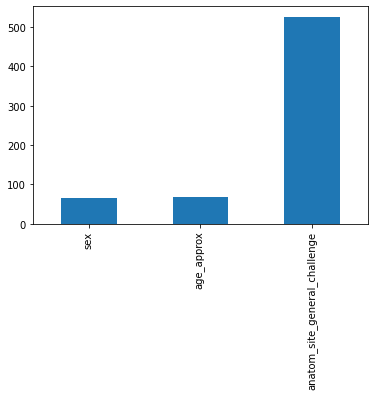

Total   Percent
anatom_site_general_challenge  527.0  1.590895
age_approx                      68.0  0.205277
sex                             65.0  0.196220

In [15]:
print("                 Missing Values of Train",)
missing_values(train)
missing_values_table(train)

                 Missing Values of Test


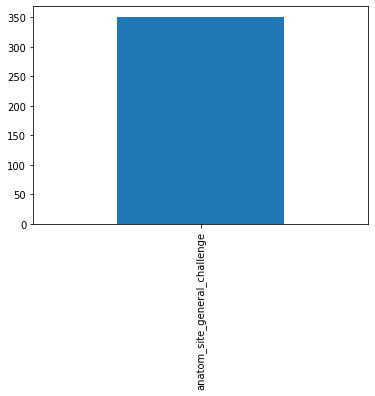

Total   Percent
anatom_site_general_challenge  351.0  3.196139

In [16]:
print("                 Missing Values of Test",)
missing_values(test)
missing_values_table(test)

In [17]:
def plot(df,column):
    target_count = df[column].value_counts()  
    plt.figure(figsize=(6,4))
    sns.barplot(target_count.index, target_count.values, alpha=1)
    plt.ylabel('Number of Data', fontsize=12)
    plt.xlabel('target', fontsize=9)
    plt.xticks(rotation=90)
    print(target_count)
    plt.show()

male      17080

female    15981

Name: sex, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  FutureWarning


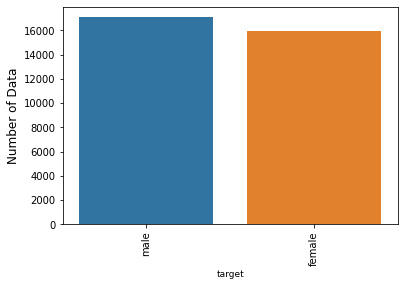

In [18]:
plot(train,'sex')

In [19]:
train['sex'].fillna("male", inplace = True) 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  FutureWarning


45.0    4466

50.0    4270

55.0    3824

40.0    3576

60.0    3240

35.0    2850

65.0    2527

30.0    2358

70.0    1968

25.0    1544

75.0     981

20.0     655

80.0     419

85.0     149

15.0     132

90.0      80

10.0      17

0.0        2

Name: age_approx, dtype: int64


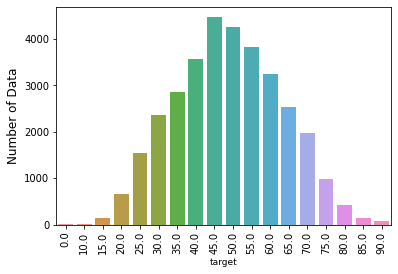

In [20]:
plot(train,'age_approx')

In [21]:
median = train['age_approx'].median()
train['age_approx'].fillna(median, inplace = True) 

torso              16845

lower extremity     8417

upper extremity     4983

head/neck           1855

palms/soles          375

oral/genital         124

Name: anatom_site_general_challenge, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  FutureWarning


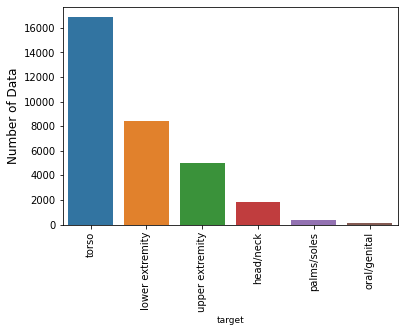

In [22]:
plot(train,'anatom_site_general_challenge')

In [23]:
train['anatom_site_general_challenge'].fillna('torso', inplace = True) 

torso              5847

lower extremity    2501

upper extremity    1573

head/neck           576

palms/soles         108

oral/genital         26

Name: anatom_site_general_challenge, dtype: int64


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

  FutureWarning


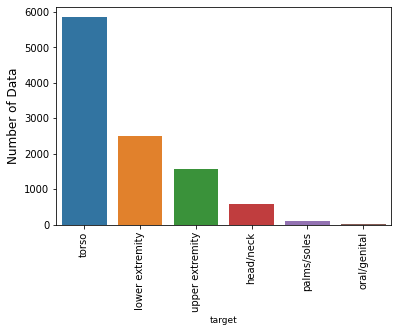

In [24]:
plot(test,'anatom_site_general_challenge')

In [25]:
test['anatom_site_general_challenge'].fillna('torso', inplace = True) 

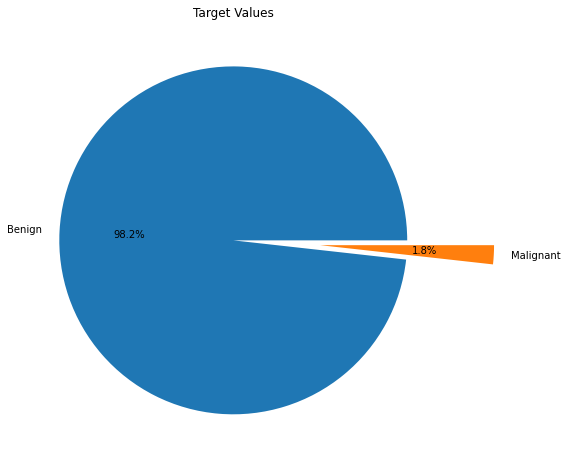

Benign cases are 98.23703435367989 %


In [26]:
plt.figure(figsize=(10, 8))
target = [len(train[train['target'] == 0]), len(train[train['target'] == 1])]
labels = ["Benign", "Malignant"]
plt.pie(x=target, labels=labels, explode=[0.0, 0.5], autopct='%1.1f%%')
plt.title("Target Values")
plt.show()
print("Benign cases are",(32542/(32542+584))*100,'%')

## **Image Analysis**
* Les images sont fournies au format DICOM. Ce format est accessible à l'aide de bibliothèques courantes comme pydicom et contient à la fois l'image et les métadonnées. Il s'agit d'un format de données d'imagerie médicale couramment utilisé.

* Les images sont également fournies au format JPEG et TFRecord (dans les répertoires jpeg et tfrecords, respectivement). Les images au format TFRecord ont été redimensionnées à une taille uniforme de 1024x1024.

> Nous allons utiliser les images a format JPEG

In [27]:
#Verification de nombres d'images
print('Train shape          :',len(list(os.listdir('../input/siim-isic-melanoma-classification/train'))))
print('Test shape           :',len(list(os.listdir('../input/siim-isic-melanoma-classification/test'))))
print('Train image shape    :',len(list(os.listdir('../input/siim-isic-melanoma-classification/jpeg/train'))))
print('Test image shape     :',len(list(os.listdir('../input/siim-isic-melanoma-classification/jpeg/test'))))

Train shape          : 33126

Test shape           : 10982

Train image shape    : 33126

Test image shape     : 10982


> Puisque le compte est bon alors on peut commencer a visualiser les images

In [28]:
#Taille de l'image
img = Image.open('/kaggle/input/siim-isic-melanoma-classification/jpeg/test/ISIC_0073313.jpg')
print(img.size)

(6000, 4000)


In [29]:
def display_training_curves(training, validation, title):
    plt.figure(figsize=(10,5))
    plt.plot(training)
    plt.plot(validation)
    plt.title('model '+ title)
    plt.ylabel(title)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

def grid_display(list_of_images, title = None, nb_columns=4, figsize=(20,15)):
    n = len(list_of_images)
    rows = n // nb_columns + (n % nb_columns != 0)
    fig, axes = plt.subplots(rows, nb_columns, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < n:
            ax.imshow(list_of_images[i])
            if title:
                ax.set_title(title[i])
            ax.axis('off')
    plt.show()


fonction **display_training_curves** : va créer une nouvelle figure et tracer les données de formation et de validation sur le même graphique. La figure aura un titre, une étiquette sur l'axe des y, une étiquette sur l'axe des x, et la légende aura des étiquettes 'formation' et 'validation'.

Cette fonction prend trois paramètres :

formation : liste de données de formation
validation : liste de données de validation
title : chaîne de caractères, titre du graphique
De plus, elle n'utilisera pas de sous-points et utilisera 'plt.show()' pour afficher le graphique, il n'est pas nécessaire d'utiliser des sous-points pour ce cas d'utilisation, il s'agit de simplifier le code en supprimant les lignes inutiles.


fonction **grid_display** prendra les mêmes paramètres que la fonction précédente :

list_of_images : liste d'images
title : liste de chaînes de caractères, titres des images
no_of_columns : nombre de colonnes dans la grille d'affichage
figsize : taille de la figure
Ce code affichera les images dans un format de grille, avec un nombre de colonnes spécifié, les images seront affichées sans axe, et si des titres sont fournis, ils seront affichés en haut de chaque image.

Il utilise la fonction subplots de matplotlib pour créer la grille, et il utilise également plt.show() pour afficher les images. Le code est simplifié en supprimant les variables et les boucles inutiles, et il gère également le cas où le nombre d'images n'est pas divisible par le nombre de colonnes.


         ----------------benign images----------------


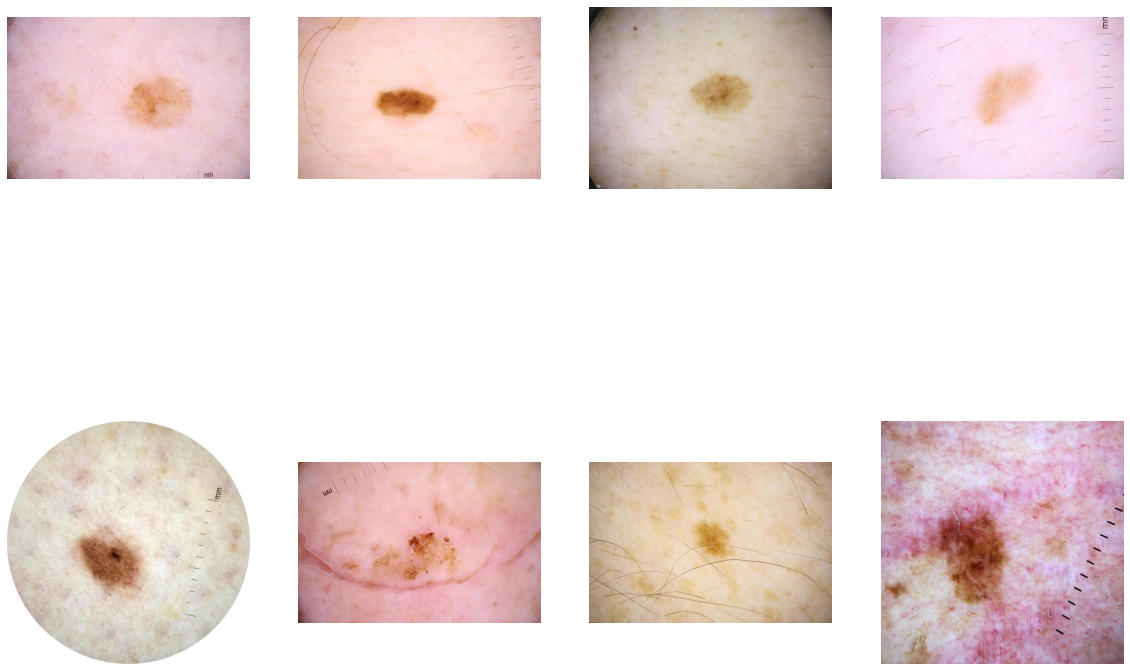

In [30]:
image_list = train[train['target'] == 0].sample(8)['image_name']
image_all=[]
for image_id in image_list:
    image_file = f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+image_id+'.jpg' 
    img = np.array(Image.open(image_file))
    image_all.append(img)
#show_images(image_all, cols=1)
print("         ----------------benign images----------------")
grid_display(image_all)

         ----------------malignant images----------------


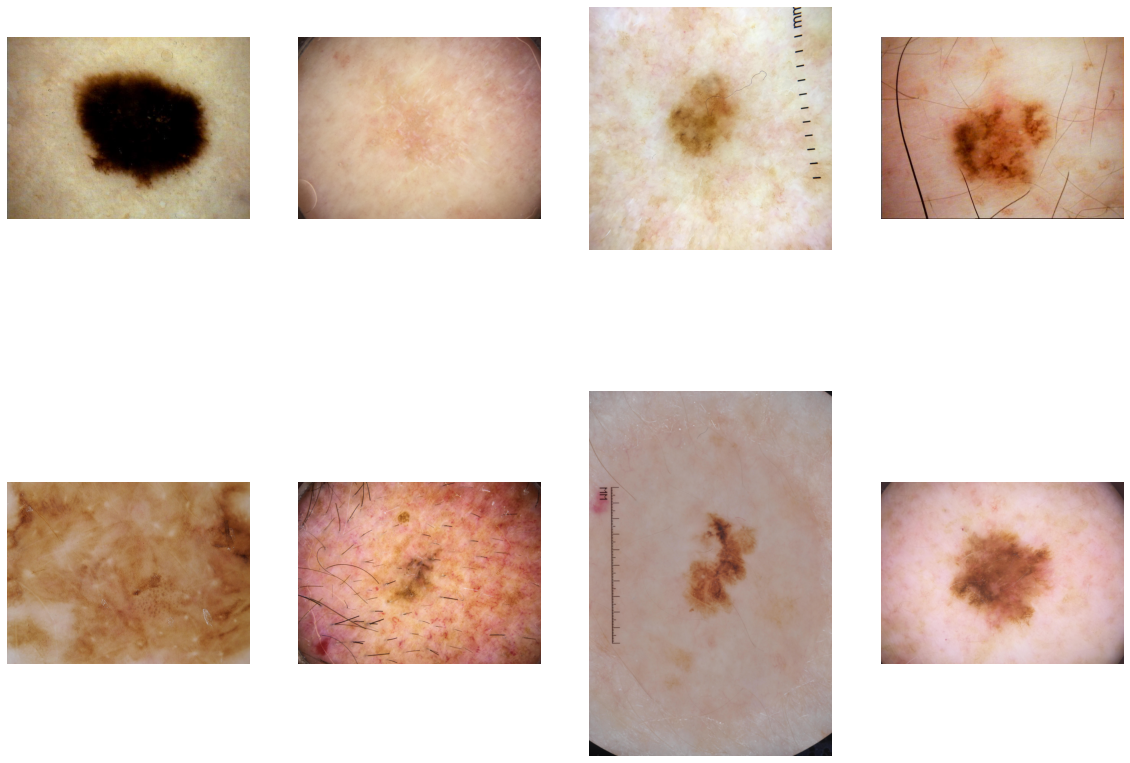

In [31]:
image_list = train[train['target'] == 1].sample(8)['image_name']
image_all=[]
for image_id in image_list:
    image_file = f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+image_id+'.jpg' 
    img = np.array(Image.open(image_file))
    image_all.append(img)
#show_images(image_all, cols=1)
print("         ----------------malignant images----------------")
grid_display(image_all)

Ce code sélectionnera 8 images aléatoires de l'ensemble de données de formation où la colonne cible est égale à 0 et il chargera les fichiers d'image correspondants du répertoire, et il les stockera dans la liste image_all.

Le code utilise les chaînes f (f"...") pour concaténer le chemin et le nom de l'image, c'est plus lisible et plus efficace que l'opérateur +.

Il utilise également la fonction grid_display pour afficher les images.

Il n'utilise pas non plus la fonction show_images, il utilise la fonction grid_display que j'ai fournie précédemment, il fait la même chose en affichant les images dans un format de grille.

               ---------------- head/neck images----------------


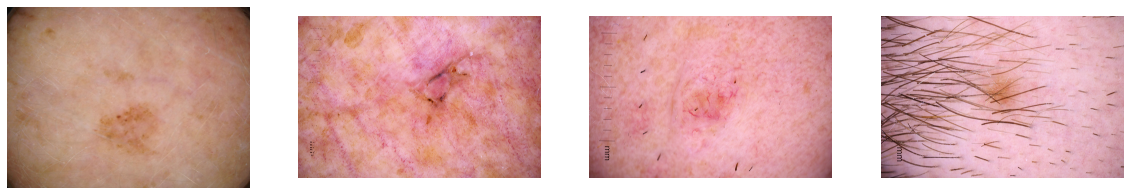

               ---------------- upper extremity images----------------


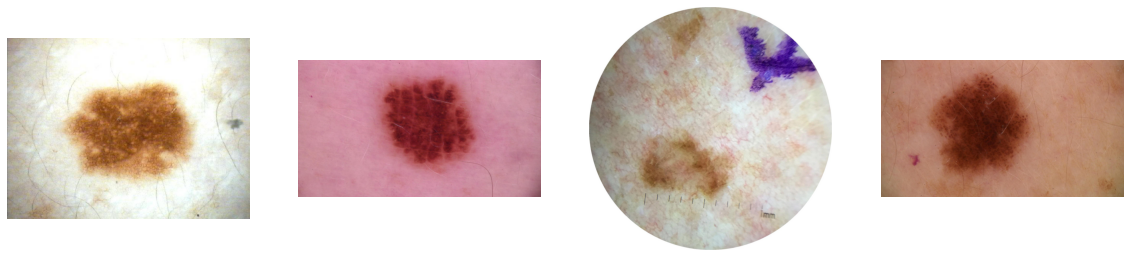

               ---------------- lower extremity images----------------


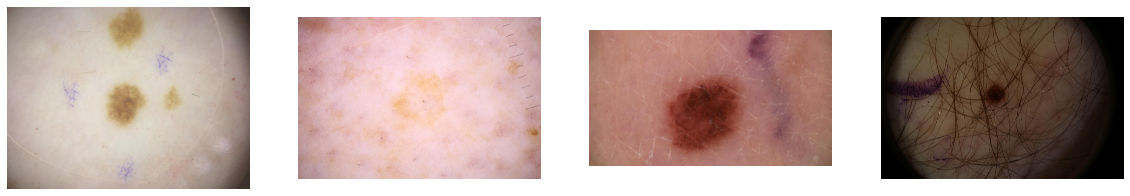

               ---------------- torso images----------------


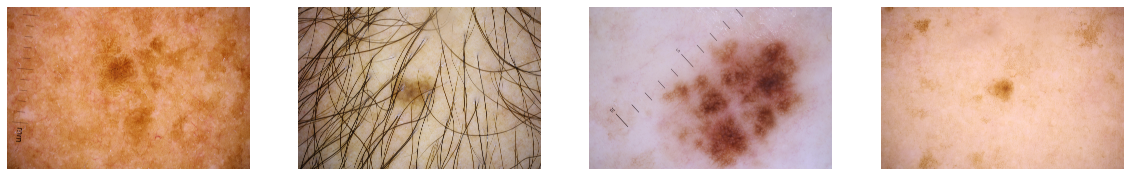

               ---------------- palms/soles images----------------


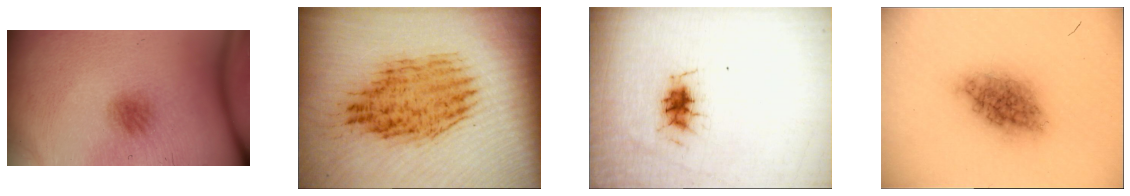

               ---------------- oral/genital images----------------


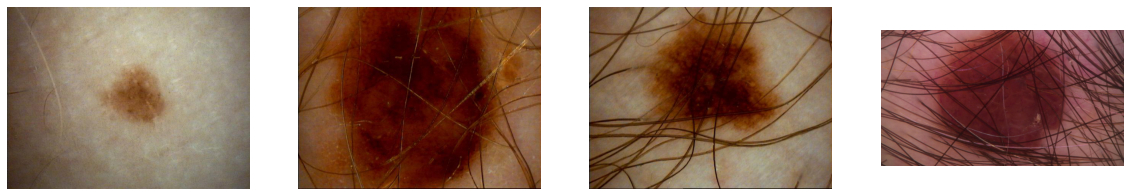

In [26]:
l = train['anatom_site_general_challenge'].unique()
for i in l :
    image_list = train[train['anatom_site_general_challenge'] == i].sample(4)['image_name']
    image_all=[]
    for image_id in image_list:
        image_file = f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'+image_id+'.jpg' 
        img = np.array(Image.open(image_file))
        image_all.append(img)
#show_images(image_all, cols=1)
    print("               ----------------" ,i,"images----------------")
    grid_display(image_all)

## **Preprocessing**

In [8]:
df_begnin=train[train['target']==0].sample(1500) ## produire un cadre de données en utilisant 1000 images de l'ensemble de données de formation où la cible est égale à zéro.
df_mal=train[train['target']==1] ## produire un cadre de données utilisant toutes les images de l'ensemble de données de test où la cible est égale à 584
train=pd.concat([df_begnin,df_mal]) ## créer un nouvel ensemble de données en utilisant l'ensemble de données d'entraînement plus petit
train=train.reset_index() 

In [9]:
labels=[]
data_img=[]
for i in range(train.shape[0]):
    data_img.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
new_train=pd.DataFrame(data_img)
new_train.columns=['images']
new_train['target']=labels

In [10]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
new_test=pd.DataFrame(test_data)
new_test.columns=['images']

In [11]:
X_train, X_val, y_train, y_val = train_test_split(new_train['images'],new_train['target'], test_size=0.15, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

In [12]:
print("Train      :",len(X_train))
print("Validation :",len(X_val))

Train      : 1771

Validation : 313


## **Data Normalisation + Data Augmentation**

1. Initialisation de l'objet ImageDataGenerator avec les différentes options de transformation

In [21]:

train_gen = ImageDataGenerator(
        rescale=1./255.,# Normalisation des valeurs de pixels
        rotation_range=30, # Rotation aléatoire des images
        width_shift_range=0.2,# Translation horizontale aléatoire
        height_shift_range=0.2, # Translation verticale aléatoire
        shear_range=0.2, # Inclinaison aléatoire
        zoom_range=0.2, # Zoom aléatoire
        horizontal_flip=True, # Retournement horizontal aléatoire
        fill_mode='nearest'# Remplissage des pixels créés par les transformations
)

valid_gen = ImageDataGenerator(rescale=1./255)

Ce code crée un générateur d'images pour un entraînement en utilisant la classe ImageDataGenerator de Keras. Il configure les différentes options de transformation disponibles pour augmenter les données d'entraînement. Les options spécifiées incluent :

* rescale : réduit les valeurs de tous les pixels de l'image par 255 (normalisation des valeurs).

* rotation_range : génère des images en rotation aléatoire avec une amplitude de rotation de 30 degrés.

* width_shift_range and height_shift_range : génère des images en décalant horizontalement et verticalement les images avec une amplitude de 0,2.

* shear_range : génère des images en inclinant les images aléatoirement avec une amplitude de 0,2.

* zoom_range : génère des images en zoomant aléatoirement avec une amplitude de 0,2.

* horizontal_flip : génère des images en les retournant horizontalement avec une probabilité de 50%.

* fill_mode : définit la stratégie pour remplir les pixels créés lors des transformations. Ici il est défini à 'nearest' pour remplir les pixels avec les valeurs les plus proches.

> Ce générateur d'images est utilisé pour alimenter un modèle de réseau de neurones en augmentant les données d'entraînement pour éviter le sur-apprentissage.

In [14]:
train_img_path='/kaggle/input/siim-isic-melanoma-classification/train'
train_dir = pathlib.Path(train_img_path)
test_img_path='/kaggle/input/siim-isic-melanoma-classification/test'
test_dir = pathlib.Path(test_img_path)

2. Utilisation de la méthode flow_from_dataframe pour charger les images à partir d'une dataframe et les prétraiter en utilisant les options spécifiées:

In [15]:
# generate training data
train_generator = train_gen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    subset="training",
    batch_size=16,
    seed=50,
    class_mode="raw", #Mode de classification pour les images
    shuffle=True,
    target_size=(128,128)# Taille cible pour les images) 

validation_generator = valid_gen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(128, 128),
    shuffle=False,
    batch_size=16,
    seed=50,
    class_mode='raw')

Found 1771 validated image filenames.

Found 313 validated image filenames.


## Model 1 :
### input image : 128*128 + Data regularisation + shuffle = False for Validation

In [16]:

# Create the model
model = keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


2023-01-14 09:32:55.877589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-01-14 09:32:55.884430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-01-14 09:32:55.885243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2023-01-14 09:32:55.887366: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA

To enable them in other operations, rebuild TensorFlow with the appropriate co

Ici nous avons créer un CNN qui utilise la classe Sequential pour initialiser un modèle vide puis on a ajoutés les couches suivants :
* Une couche de convolution 2D avec 32 filtres de taille 3x3, une fonction d'activation ReLU et une forme d'entrée de (128, 128, 3) pour traiter les images.
* Une autre couche de convolution 2D avec 32 filtres de taille 3x3 et une fonction d'activation ReLU.
* Une couche de max pooling 2D de taille (2, 2) pour réduire la dimension de l'image en divisant par 2 en largeur et en hauteur.
* Une couche de dropout avec un taux de dropout de 0.5, cette couche permet de réduire l'overfitting.

*  une couche de Flatten qui permet de transformer les données de la forme 3D (hauteur, largeur, profondeur) en une forme 1D pour faciliter l'entrée dans les couches fully connected (ou dense) suivantes.
* Une couche dense avec 512 neurones et une fonction d'activation ReLU.
* Une couche dense de sortie avec un neurone et une fonction d'activation sigmoïde pour produire une prédiction binaire.
et nous avons utiliser l'optimiseur Adam , la fonction de coût "binary_crossentropy" pour les tâches de classification binaire et les métriques "accuracy" pour suivre la précision de la classification.

In [17]:
model.summary()

Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d (Conv2D)              (None, 126, 126, 32)      896       

_________________________________________________________________

conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      

_________________________________________________________________

max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         

_________________________________________________________________

dropout (Dropout)            (None, 62, 62, 32)        0         

_________________________________________________________________

conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     

_________________________________________________________________

conv2d_3 (Conv2D)            (None, 58, 58, 64)        36928     

_________________________________________________________________

max_pooling2d_1 (MaxPooling2 (None, 29, 

In [18]:
history=model.fit(x=train_generator, epochs=6, validation_data=validation_generator)

2023-01-14 09:33:02.653033: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6


2023-01-14 09:33:06.761095: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


111/111 [==============================] - 339s 3s/step - loss: 0.5975 - accuracy: 0.7171 - val_loss: 0.5803 - val_accuracy: 0.6997

Epoch 2/6

111/111 [==============================] - 290s 3s/step - loss: 0.5941 - accuracy: 0.7233 - val_loss: 0.6036 - val_accuracy: 0.6997

Epoch 3/6

111/111 [==============================] - 303s 3s/step - loss: 0.5777 - accuracy: 0.7233 - val_loss: 0.5839 - val_accuracy: 0.6997

Epoch 4/6

111/111 [==============================] - 300s 3s/step - loss: 0.5630 - accuracy: 0.7233 - val_loss: 0.5779 - val_accuracy: 0.6997

Epoch 5/6

111/111 [==============================] - 301s 3s/step - loss: 0.5607 - accuracy: 0.7233 - val_loss: 0.5676 - val_accuracy: 0.6997

Epoch 6/6

111/111 [==============================] - 301s 3s/step - loss: 0.5783 - accuracy: 0.7233 - val_loss: 0.5793 - val_accuracy: 0.6997


* "Layer (type)" indique le type de couche, comme conv2D, max_pooling2D, dense, etc.
* "Output Shape" indique la forme de la sortie de chaque couche.
* "Param #" indique le nombre de paramètres utilisés dans chaque couche.

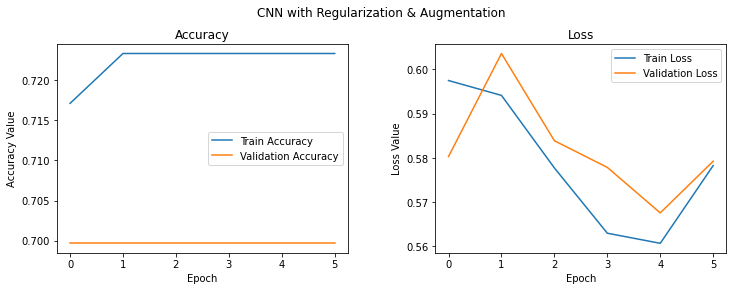

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Regularization & Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,6))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


* Quand la précision du training est supérieure à la précision de validation et qu'il y a un écart important entre les deux, c'est un indicateur de surapprentissage et ici notre modèle n'arrive meme pas a apprendre car la valeur de la précision reste ègal à 0 au niveau des 6 epochs ce qui n'est pas du tout bien .
* au niveau de la loss value on a  la valeur de perte de validation est supérieure à celle de la perte d'entraînement, cela signifie généralement que le modèle est sur-ajusté.Cela peut se produire lorsque le modèle est trop complexe pour la distribution de données d'entraînement, et il est donc trop spécialisé pour les données d'entraînement et ne généralise pas bien aux données de validation. 

## Model 2 : input image : 28*28 + shuffle=True for validation

In [22]:
# generate training data
train_generator = train_gen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    subset="training",
    batch_size=16,
    seed=50,
    class_mode="raw",
    shuffle=True,
    target_size=(28,28)) 

validation_generator = valid_gen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(28, 28),
    shuffle=True,
    batch_size=16,
    seed=50,
    class_mode='raw')

Found 1027 validated image filenames.

Found 257 validated image filenames.


In [39]:
model = keras.Sequential()
model.add(layers.Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(layers.Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D(pool_size = (2,2), padding = 'same'))

model.add(Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss = 'binary_crossentropy',
             optimizer = optimizer,
              metrics = ['accuracy'])
print(model.summary())

Model: "sequential_11"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_15 (Conv2D)           (None, 28, 28, 16)        448       

_________________________________________________________________

max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         

_________________________________________________________________

conv2d_16 (Conv2D)           (None, 14, 14, 32)        4640      

_________________________________________________________________

max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         

_________________________________________________________________

conv2d_17 (Conv2D)           (None, 7, 7, 64)          18496     

_________________________________________________________________

max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         

_________________________________________________________________

conv2d_18 (Conv2D)           (None, 4

In [41]:
history2=model.fit(x=train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10

111/111 [==============================] - 306s 3s/step - loss: 0.5685 - accuracy: 0.7233 - val_loss: 0.5723 - val_accuracy: 0.6997

Epoch 2/10

111/111 [==============================] - 291s 3s/step - loss: 0.5527 - accuracy: 0.7199 - val_loss: 0.5369 - val_accuracy: 0.7125

Epoch 3/10

111/111 [==============================] - 310s 3s/step - loss: 0.5607 - accuracy: 0.7194 - val_loss: 0.5794 - val_accuracy: 0.6997

Epoch 4/10

111/111 [==============================] - 293s 3s/step - loss: 0.5312 - accuracy: 0.7199 - val_loss: 0.5097 - val_accuracy: 0.7157

Epoch 5/10

111/111 [==============================] - 292s 3s/step - loss: 0.5273 - accuracy: 0.7233 - val_loss: 0.5212 - val_accuracy: 0.7157

Epoch 6/10

111/111 [==============================] - 300s 3s/step - loss: 0.5154 - accuracy: 0.7233 - val_loss: 0.5077 - val_accuracy: 0.7220

Epoch 7/10

111/111 [==============================] - 292s 3s/step - loss: 0.5050 - accuracy: 0.7380 - val_loss: 0.4932 - val_acc

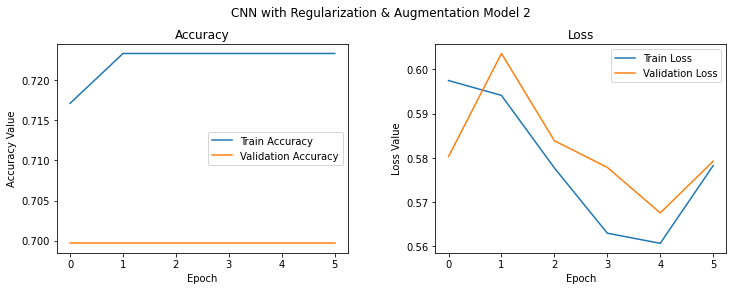

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Regularization & Augmentation Model 2', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,6))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


ici on remarque qu'on a le meme probleme que le premier modele

In [59]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)
    

0 conv2d_15 (None, 28, 28, 16)

2 conv2d_16 (None, 14, 14, 32)

4 conv2d_17 (None, 7, 7, 64)

6 conv2d_18 (None, 4, 4, 128)


## Model 3 : input image : 128*128 + Suffle=True for validation + equilibrage du train et validation + Epoch= 30

In [4]:
train = pd.read_csv(train_path)

df_begnin=train[train['target']==0].sample(600)
df_mal=train[train['target']==1] 
train=pd.concat([df_begnin,df_mal]) 
train=train.reset_index() 


In [5]:
labels=[]
data_img=[]
for i in range(train.shape[0]):
    data_img.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
new_train=pd.DataFrame(data_img)
new_train.columns=['images']
new_train['target']=labels

In [7]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
new_test=pd.DataFrame(test_data)
new_test.columns=['images']

In [8]:
X_train, X_val, y_train, y_val = train_test_split(new_train['images'],new_train['target'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

In [9]:
train_gen = ImageDataGenerator(
        rescale=1./255.,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

valid_gen = ImageDataGenerator(rescale=1./255)

In [10]:
# generate training data
train_generator = train_gen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    subset="training",
    batch_size=30,
    seed=50,
    class_mode="raw",
    shuffle=True,
    target_size=(128,128)) 

validation_generator = valid_gen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(128,128),
    shuffle=True,
    batch_size=30,
    seed=50,
    class_mode='raw')

Found 947 validated image filenames.
Found 237 validated image filenames.


In [11]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001,decay=1e-5)

model.compile(loss="binary_crossentropy",
             optimizer = optimizer,
              metrics = ['accuracy'])
print(model.summary())

2023-01-15 18:16:51.848169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 18:16:51.849095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 18:16:51.852452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 18:16:51.853238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 18:16:51.854009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [12]:
history3=model.fit(x=train_generator, epochs=30, validation_data=validation_generator)

2023-01-15 18:17:00.975125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-15 18:17:08.687454: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


32/32 [==============================] - 181s 5s/step - loss: 0.6912 - accuracy: 0.5185 - val_loss: 0.6967 - val_accuracy: 0.4979
Epoch 2/30
32/32 [==============================] - 149s 5s/step - loss: 0.6874 - accuracy: 0.5301 - val_loss: 0.6807 - val_accuracy: 0.5865
Epoch 3/30
32/32 [==============================] - 149s 5s/step - loss: 0.6787 - accuracy: 0.5797 - val_loss: 0.6902 - val_accuracy: 0.5190
Epoch 4/30
32/32 [==============================] - 151s 5s/step - loss: 0.6586 - accuracy: 0.6346 - val_loss: 0.6434 - val_accuracy: 0.6287
Epoch 5/30
32/32 [==============================] - 158s 5s/step - loss: 0.6256 - accuracy: 0.6420 - val_loss: 0.7112 - val_accuracy: 0.5738
Epoch 6/30
32/32 [==============================] - 159s 5s/step - loss: 0.6098 - accuracy: 0.6610 - val_loss: 0.6318 - val_accuracy: 0.6456
Epoch 7/30
32/32 [==============================] - 153s 5s/step - loss: 0.5873 - accuracy: 0.6779 - val_loss: 0.6537 - val_accuracy: 0.6540
Epoch 8/30
32/32 [======

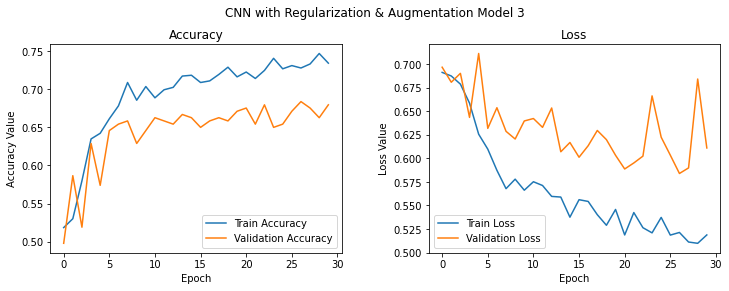

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Regularization & Augmentation Model 3', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,30))
ax1.plot(epoch_list, history3.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history3.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history3.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Ici on peut remarquer qu'on augmentant le nombre d'epochs l'accuracy a pu atteindre une valeur presque égal à 75% ce qui est mieux car elle représente le pourcentage de prédictions correctes sur l'ensemble des prédictions effectuées et plus l'accuracy est élevée, meilleure est la performance du modèle donc ici notre modèle est entrain de mieux apprendre mais il parait qu'il est entrain de faire un overfiting car la courbe de la validation est entrain de suivre la courbe du training ce qui n'est pas aussi bon donc on peut vérifier si le modèle est bon ou non avec la matrice de confusion car l'accuracy n'est pas toujours un indicateur fiable de la performance d'un modèle.

True Neagtive: 62 
 False Positive: 56 
 False Negative: 55 
 True Positive: 64


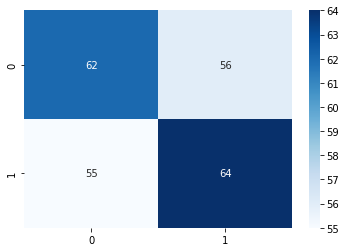

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = model.predict(validation_generator)
def conf_matrix():
    y_pred = model.predict(validation_generator)
    y_pred = [ 1 if i <0.5 else 0 for i in y_pred ]
    y_true = validation_generator.labels
    matrix = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    print("True Neagtive:",tn,"\n False Positive:" ,fp,"\n False Negative:", fn,"\n True Positive:", tp)
    sns.heatmap(matrix, annot=True, cmap='Blues')

conf_matrix()

* True Neagtive: 62, cela signifie que 62 éléments ont été correctement classés comme appartenant à la classe négative.
* False Positive: 56, cela signifie que 56 éléments ont été incorrectement classés comme appartenant à la classe positive.
* False Negative: 55, cela signifie que 55 éléments ont été incorrectement classés comme appartenant à la classe négative.
* True Positive: 64, cela signifie que 64 éléments ont été correctement classés comme appartenant à la classe positive.

> En regardant ces indicateurs avec les données que vous avez donné, on peut voir que le modèle a une précision de 53% (64/(64+56)), et un rappel de 53,6% (64/(64+55)), cela signifie qu'il prédit correctement 53% des cas positifs et il a réussi à détecter 53,6% des cas positifs réels. Ces résultats ne sont pas très élevés, il est donc possible que le modèle ne soit pas performant. 

Visualisation des features Maps :

In [17]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

0 conv2d (None, 126, 126, 16)
2 conv2d_1 (None, 61, 61, 64)
4 conv2d_2 (None, 28, 28, 128)
6 conv2d_3 (None, 12, 12, 128)


In [19]:
from tensorflow.keras.models import Model
model = Model(inputs=model.inputs , outputs=model.layers[1].output)

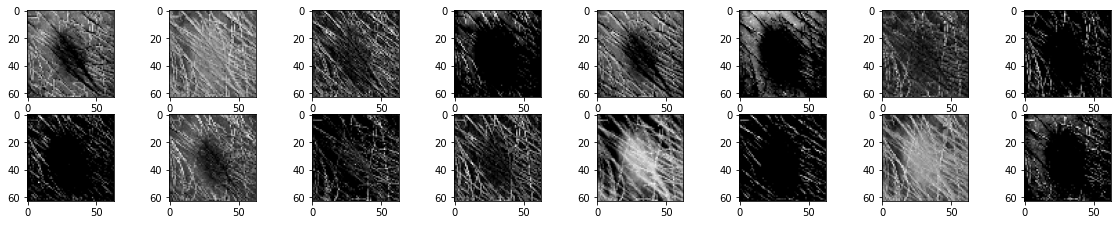

In [25]:
image = load_img("/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_0068279.jpg" , target_size=(128,128))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)
image = preprocess_input(image)
#calculating features_map
features = model.predict(image)

fig = pyplot.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(features[0,:,:,i-1] , cmap='gray')
    
pyplot.show()

In [6]:
df_begnin=train[train['target']==0].sample(700) ## produce a data frame using 1000 images from the train data set where the target equals zero
df_mal=train[train['target']==1] ## produce a data frame using all the images from the test data set where the target equals 584
train=pd.concat([df_begnin,df_mal]) ## create a new dataset using the smaller training data set
train=train.reset_index() ## making sure the new "train" data set is being used for the model

In [7]:
labels=[]
data_img=[]
for i in range(train.shape[0]):
    data_img.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
new_train=pd.DataFrame(data_img)
new_train.columns=['images']
new_train['target']=labels

In [10]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
new_test=pd.DataFrame(test_data)
new_test.columns=['images']

In [8]:
X_train, X_val, y_train, y_val = train_test_split(new_train['images'],new_train['target'], test_size=0.15, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

In [9]:
print("Train      :",len(X_train))
print("Validation :",len(X_val))

Train      : 1091

Validation : 193


## Modele 4 : image_input :28*28 img + focal loss

In [14]:
train_gen = ImageDataGenerator(
        rescale=1./255.,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

valid_gen = ImageDataGenerator(rescale=1./255)

In [14]:
train_img_path='/kaggle/input/siim-isic-melanoma-classification/train'
train_dir = pathlib.Path(train_img_path)
test_img_path='/kaggle/input/siim-isic-melanoma-classification/test'
test_dir = pathlib.Path(test_img_path)

In [15]:
# generate training data
train_generator = train_gen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    subset="training",
    batch_size=16,
    seed=50,
    class_mode="raw",
    shuffle=True,
    target_size=(128,128)) 

validation_generator = valid_gen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(128, 128),
    shuffle=True,
    batch_size=16,
    seed=50,
    class_mode='raw')

Found 1771 validated image filenames.

Found 313 validated image filenames.


**Model 4 : Utilisation du focal loss**

In [10]:
from focal_loss import binary_focal_loss
from focal_loss import BinaryFocalLoss

In [33]:
# generate training data
train_generator = train_gen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    subset="training",
    batch_size=16,
    seed=50,
    class_mode="raw",
    shuffle=True,
    target_size=(28,28)) 

validation_generator = valid_gen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(28, 28),
    shuffle=True,
    batch_size=16,
    seed=50,
    class_mode='raw')

Found 1771 validated image filenames.

Found 313 validated image filenames.


In [44]:
    model = Sequential()
    model.add(layers.Conv2D(16, kernel_size = (3,3), input_shape = (28,28,3), activation = 'relu'))
    model.add(layers.MaxPool2D(pool_size = (2,2)))

    model.add(layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(layers.MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(layers.Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(layers.MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = BinaryFocalLoss(gamma=2),
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())

Model: "sequential_8"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d_30 (Conv2D)           (None, 26, 26, 16)        448       

_________________________________________________________________

max_pooling2d_22 (MaxPooling (None, 13, 13, 16)        0         

_________________________________________________________________

conv2d_31 (Conv2D)           (None, 13, 13, 32)        4640      

_________________________________________________________________

max_pooling2d_23 (MaxPooling (None, 7, 7, 32)          0         

_________________________________________________________________

conv2d_32 (Conv2D)           (None, 7, 7, 64)          18496     

_________________________________________________________________

max_pooling2d_24 (MaxPooling (None, 4, 4, 64)          0         

_________________________________________________________________

conv2d_33 (Conv2D)           (None, 4,

Total params: 132,385" indique le nombre total de paramètres utilisés dans le modèle entier.

In [45]:
history2=model.fit(x=train_generator, epochs=6, validation_data=validation_generator)

Epoch 1/6

111/111 [==============================] - 314s 3s/step - loss: 0.1471 - accuracy: 0.7177 - val_loss: 0.1472 - val_accuracy: 0.6997

Epoch 2/6

111/111 [==============================] - 331s 3s/step - loss: 0.1413 - accuracy: 0.7233 - val_loss: 0.1528 - val_accuracy: 0.6997

Epoch 3/6

111/111 [==============================] - 316s 3s/step - loss: 0.1351 - accuracy: 0.7205 - val_loss: 0.1384 - val_accuracy: 0.6965

Epoch 4/6

111/111 [==============================] - 307s 3s/step - loss: 0.1302 - accuracy: 0.7239 - val_loss: 0.1295 - val_accuracy: 0.7252

Epoch 5/6

111/111 [==============================] - 311s 3s/step - loss: 0.1301 - accuracy: 0.7250 - val_loss: 0.1561 - val_accuracy: 0.6965

Epoch 6/6

111/111 [==============================] - 322s 3s/step - loss: 0.1289 - accuracy: 0.7261 - val_loss: 0.1422 - val_accuracy: 0.6997


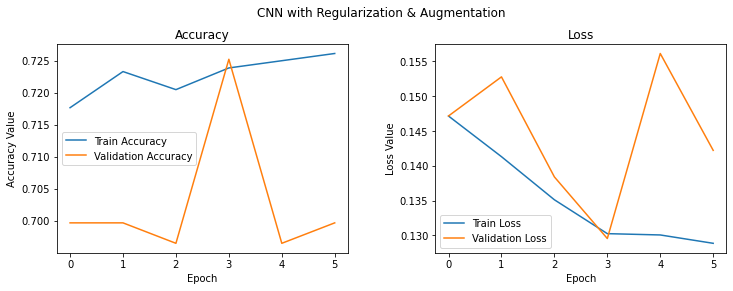

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Regularization & Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,6))
ax1.plot(epoch_list, history2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history2.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Ici nous avons utiliser la focal loss qui est ne modification de la loss classique utilisée pour les modèles de classification. Elle a été développée pour traiter les problèmes de déséquilibre de classe, où il y a un grand déséquilibre entre les exemples d'une classe et les exemples des autres classes. La focal loss permet de donner plus de poids aux erreurs sur les exemples difficiles à classer, c'est-à-dire ceux qui appartiennent à une classe minoritaire.

En utilisant cette fonction de perte, le modèle est incité à se concentrer davantage sur les exemples difficiles à classer, ce qui peut améliorer sa performance globale sur les classes minoritaires.

* Ici on peut remarquer que la courbe de l'Accuracy est au dessous de celle du Training mais il y a une pique assez importante au niveau de l'epoch 3 qui arrive a atteindre les 72% mais aprés il y a une chutte assez importante . Le modèle ici n'est pas trés mauvais car on remarque qu'il n'y a pas de overfitting mais il peut etre mieux règler 

# **Transfer Learning** :

## **Model 1 : VGG16**

In [26]:

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
def build_model():
    inputs = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(inputs)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(1, activation='sigmoid', name='fc3')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

In [27]:
import h5py
model= build_model()

f = h5py.File('../input/vgg16yessth/vgg16_weights_tf_dim_ordering_tf_kernels.h5', 'r')

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

Model: "model_1"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         

_________________________________________________________________

Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      

_________________________________________________________________

Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     

_________________________________________________________________

pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         

_________________________________________________________________

Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      

_________________________________________________________________

Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     

_________________________________________________________________

pool2 (MaxPooling2D)         (None, 56, 56,

In [15]:
train_generator = train_gen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    subset="training",
    batch_size=16,
    seed=50,
    class_mode="raw",
    shuffle=True,
    target_size=(224,224)) 
validation_generator = valid_gen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(224,224),
    shuffle=True,
    batch_size=16,
    seed=50,
    class_mode='raw')

Found 1091 validated image filenames.

Found 193 validated image filenames.


In [28]:
opt = Adam(learning_rate=0.0001, decay=1e-5)
model.compile(  loss = BinaryCrossentropy(),
                 optimizer = opt,
                  metrics = ['accuracy'])

In [30]:
 history= model.fit(x=train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10

69/69 [==============================] - 223s 3s/step - loss: 0.6266 - accuracy: 0.6379 - val_loss: 0.6958 - val_accuracy: 0.4974

Epoch 2/10

69/69 [==============================] - 196s 3s/step - loss: 0.6108 - accuracy: 0.6480 - val_loss: 0.6944 - val_accuracy: 0.4974

Epoch 3/10

69/69 [==============================] - 199s 3s/step - loss: 0.6048 - accuracy: 0.6755 - val_loss: 0.6949 - val_accuracy: 0.4974

Epoch 4/10

69/69 [==============================] - 207s 3s/step - loss: 0.5943 - accuracy: 0.6856 - val_loss: 0.6929 - val_accuracy: 0.4974

Epoch 5/10

69/69 [==============================] - 193s 3s/step - loss: 0.5943 - accuracy: 0.6865 - val_loss: 0.6937 - val_accuracy: 0.4974

Epoch 6/10

69/69 [==============================] - 200s 3s/step - loss: 0.5974 - accuracy: 0.6700 - val_loss: 0.6876 - val_accuracy: 0.7306

Epoch 7/10

69/69 [==============================] - 194s 3s/step - loss: 0.5788 - accuracy: 0.6810 - val_loss: 0.6941 - val_accuracy: 0.4974


In [31]:
 history= model.fit(x=train_generator, epochs=15, validation_data=validation_generator)

Epoch 1/15

69/69 [==============================] - 198s 3s/step - loss: 0.5827 - accuracy: 0.6801 - val_loss: 0.5585 - val_accuracy: 0.7150

Epoch 2/15

69/69 [==============================] - 197s 3s/step - loss: 0.5741 - accuracy: 0.6829 - val_loss: 0.6439 - val_accuracy: 0.6684

Epoch 3/15

69/69 [==============================] - 202s 3s/step - loss: 0.5655 - accuracy: 0.6884 - val_loss: 0.6201 - val_accuracy: 0.6425

Epoch 4/15

69/69 [==============================] - 222s 3s/step - loss: 0.5645 - accuracy: 0.6984 - val_loss: 0.5618 - val_accuracy: 0.6632

Epoch 5/15

69/69 [==============================] - 204s 3s/step - loss: 0.5685 - accuracy: 0.6920 - val_loss: 0.6185 - val_accuracy: 0.6477

Epoch 6/15

69/69 [==============================] - 196s 3s/step - loss: 0.5677 - accuracy: 0.6939 - val_loss: 0.5087 - val_accuracy: 0.7358

Epoch 7/15

69/69 [==============================] - 197s 3s/step - loss: 0.5549 - accuracy: 0.7186 - val_loss: 0.9529 - val_accuracy: 0.5803


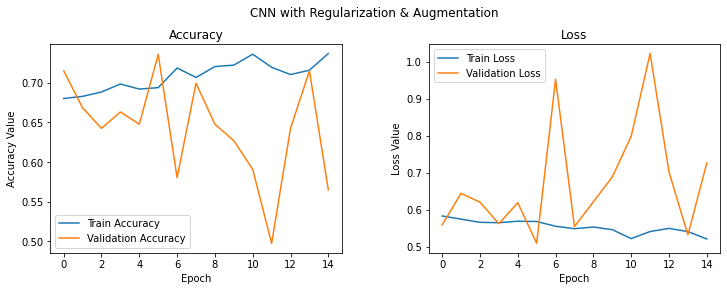

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Regularization & Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,15))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Nous pouvons remarquer que le modèle est assez performant car la courbe de validation n'est pas entrain de suivre celle du training , ce qui prouve qu'on a pas de surapprentissage . Malgré qu'il y a assez de fluctuations au niveau de la courbe de validation mais la courbe a pu aquérir une accuracy presque supèrieur à 70% ce qui montre que le modèle a pu apprendre sans overfitting mais il y a des lacunes comme pour l'epoch 11 .

Pour Loss Value : On remarque que la valeur de perte de validation est supérieure à celle de la perte d'entraînement, cela signifie généralement que le modèle est sur-ajusté donc Il est recommandé de réduire la complexité du modèle ou d'ajouter de la régularisation pour résoudre ce problème.

True Neagtive: 76 

 False Positive: 21 

 False Negative: 66 

 True Positive: 30


<AxesSubplot:>

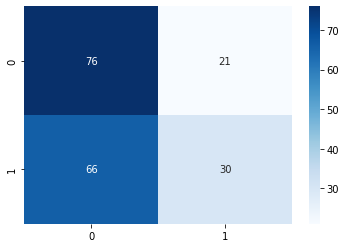

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def conf_matrix():
    y_pred = model.predict(validation_generator)
    y_pred = [ 1 if i <0.5 else 0 for i in y_pred ]
    y_true = validation_generator.labels
    matrix = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    print("True Neagtive:",tn,"\n False Positive:" ,fp,"\n False Negative:", fn,"\n True Positive:", tp)
    sns.heatmap(matrix, annot=True, cmap='Blues')

conf_matrix()

* True Neagtive: 76, cela signifie que 76 éléments ont été correctement classés comme appartenant à la classe négative.
* False Positive: 21, cela signifie que 21 éléments ont été incorrectement classés comme appartenant à la classe positive.
* False Negative: 66, cela signifie que 66 éléments ont été incorrectement classés comme appartenant à la classe négative.
* True Positive: 30, cela signifie que 30 éléments ont été correctement classés comme appartenant à la classe positive.

> En regardant ces indicateurs avec les données que vous avez donné, on peut voir que le modèle a une précision de 58,5% (30/(30+21)), et un rappel de 31,2% (30/(30+66)), cela signifie qu'il prédit correctement 58,5% des cas positifs et il a réussi à détecter 31,2% des cas positifs réels. Ces résultats peuvent être considérés comme médiocres, il est donc possible que le modèle ne soit pas performant.

## **Model 2 : Xeption**

In [67]:
    import tensorflow.keras.applications.xception as xcep
    from keras import layers
    model_xeption = tf.keras.Sequential([
        xcep.Xception(
            input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False
        ),
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation= 'relu'), 
        layers.Dropout(0.2),
        layers.Dense(512, activation= 'relu'), 
        layers.Dropout(0.2), 
        layers.Dense(256, activation='relu'), 
        layers.Dropout(0.2), 
        layers.Dense(128, activation='relu'), 
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'), 
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])
        
    model_xeption.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    model_xeption.summary()

Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


xception (Functional)        (None, 7, 7, 2048)        20861480  

_________________________________________________________________

global_average_pooling2d (Gl (None, 2048)              0         

_________________________________________________________________

dense (Dense)                (None, 1024)              2098176   

_________________________________________________________________

dropout (Dropout)            (None, 1024)              0         

_________________________________________________________________

dense_1 (Dense)              (None, 512)               524800    

_________________________________________________________________

dropout_1 (Dropout)          (None, 512)               0         

_________________________________________________________________

dense_2 (Dense)              (None, 256)

In [72]:
EPOCHS = 10
history = model_xeption.fit(  epochs=30,
x=train_generator,  validation_data=validation_generator)

Epoch 1/30

69/69 [==============================] - 222s 3s/step - loss: 0.6924 - accuracy: 0.5408 - val_loss: 0.6968 - val_accuracy: 0.5026

Epoch 2/30

69/69 [==============================] - 192s 3s/step - loss: 0.6581 - accuracy: 0.5628 - val_loss: 2.4347 - val_accuracy: 0.5492

Epoch 3/30

69/69 [==============================] - 190s 3s/step - loss: 0.6201 - accuracy: 0.6554 - val_loss: 9.8562 - val_accuracy: 0.5959

Epoch 4/30

69/69 [==============================] - 205s 3s/step - loss: 0.6132 - accuracy: 0.6297 - val_loss: 3.4195 - val_accuracy: 0.5181

Epoch 5/30

69/69 [==============================] - 192s 3s/step - loss: 0.6158 - accuracy: 0.6352 - val_loss: 0.7390 - val_accuracy: 0.5181

Epoch 6/30

69/69 [==============================] - 194s 3s/step - loss: 0.5851 - accuracy: 0.6994 - val_loss: 1.6669 - val_accuracy: 0.6891

Epoch 7/30

69/69 [==============================] - 197s 3s/step - loss: 0.5664 - accuracy: 0.7039 - val_loss: 0.5649 - val_accuracy: 0.7358


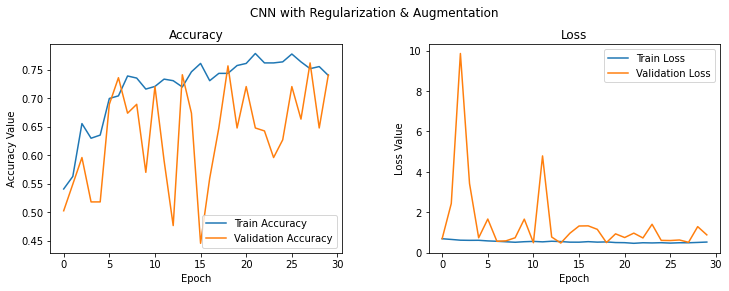

In [74]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Regularization & Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,30))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Ici on peut remarquer que l'accuracy a pu atteindre une valeur presque égal à 75% ce qui est mieux car elle représente le pourcentage de prédictions correctes sur l'ensemble des prédictions effectuées et plus l'accuracy est élevée, meilleure est la performance du modèle. donc ici notre modèle est entrain de mieux apprendre mais il parait qu'il ,'est pas entrain de faire un overfiting car la courbe de la validation n'est pas entrain de suivre la courbe du training et meme si la loss value de validation est assez importante au début , on remarque qu'a la fin la los value de validation et du training est entrain de tendre vers 0 donc cela signifie que le modèle parvient à prédire correctement les valeurs cibles pour les exemples d'entraînement. Cela indique généralement que le modèle a été bien entraîné et qu'il a appris les relations importantes entre les entrées et les sorties.

In [75]:
y_pred = model_xeption.predict(validation_generator)

True Neagtive: 44 

 False Positive: 53 

 False Negative: 42 

 True Positive: 54


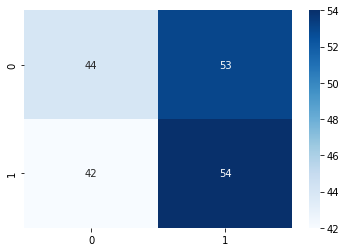

In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def conf_matrix():
    y_pred = model_xeption.predict(validation_generator)
    y_pred = [ 1 if i <0.5 else 0 for i in y_pred ]
    y_true = validation_generator.labels
    matrix = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    print("True Neagtive:",tn,"\n False Positive:" ,fp,"\n False Negative:", fn,"\n True Positive:", tp)
    sns.heatmap(matrix, annot=True, cmap='Blues')

conf_matrix()

* True Neagtive: 44, cela signifie que 44 éléments ont été correctement classés comme appartenant à la classe négative.
* False Positive: 53, cela signifie que 53 éléments ont été incorrectement classés comme appartenant à la classe positive.
* False Negative: 42, cela signifie que 42 éléments ont été incorrectement classés comme appartenant à la classe négative.
* True Positive: 54, cela signifie que 54 éléments ont été correctement classés comme appartenant à la classe positive.

>  on peut voir que le modèle a une précision de 50,4% (54/(54+53)), et un rappel de 56,2% (54/(54+42)), cela signifie qu'il prédit correctement 50,4% des cas positifs et il a réussi à détecter 56,2% des cas positifs réels. Ces résultats ne sont pas très élevés, il est donc possible que le modèle ne soit pas performant.